<a href="https://colab.research.google.com/github/antgr/keras-attention-mechanism/blob/master/Dense_and_lstm_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attention utils

In [0]:
import keras.backend as K
import numpy as np


In [2]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


Using TensorFlow backend.


In [0]:
def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


In [0]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


## Dense attention

In [0]:
import numpy as np

#from attention_utils import get_activations, get_data

np.random.seed(1337)  # for reproducibility
from keras.models import *
#from keras.layers import Input, Dense, merge
from keras.layers import Input, Dense,multiply

input_dim = 32


In [0]:
def build_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    #attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    attention_mul = multiply([inputs, attention_probs],name='attention_mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_1[0][0]                    
__________________________________________________________________________________________________
attention_mul (Multiply)        (None, 32)           0           input_1[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Train on 5000 samples, validate on 5000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 182us/step - loss: 0.6821 - acc: 0.6240 - val_loss: 0.6697 - val_acc: 0.6976
Epoch 2/20
5000/5000 [==============================] - 0s 28us/step - loss: 0.6378 - acc: 0.7474 - val_loss: 0.6003 - val_acc: 0.7844
Epoch 3/20
5000/5000 [==============================] - 0s 30us/step - loss: 0.5413 - acc: 0.7994 - val_loss: 0.4925 - val_acc: 0.8162
Epoch 4/20
5000/5000 [==============================] - 0s 38us/step - loss: 0.4277 - acc: 0.8406 - val_loss: 0.3840 - val_acc: 0.8660
Epoch 5/20
5000/5000 [==============================] - 0s 37us/step - loss: 0.3136 - acc: 0.8908 - val_loss: 0.2699 - val_acc: 0.9032
Epoch 6/20
5000/5000 [==============================] - 0s 36us/step - loss: 0.1978 - acc: 0.9482 - val_loss: 0.1558 - val_acc: 0.9600
Epoch 7/20
5000/5000 [==============================] - 0s 35us/step - loss: 0.0980 - acc: 0.9850 - val_loss: 0.0690 - val_acc: 0.9900
Epoch 

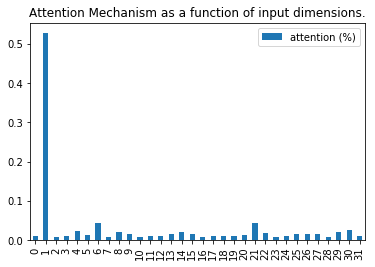

In [8]:
if __name__ == '__main__':
    N = 10000
    inputs_1, outputs = get_data(N, input_dim)

    m = build_model()
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit([inputs_1], outputs, epochs=20, batch_size=64, validation_split=0.5)

    testing_inputs_1, testing_outputs = get_data(1, input_dim)

    # Attention vector corresponds to the second matrix.
    # The first one is the Inputs output.
    attention_vector = get_activations(m, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='attention_vec')[0].flatten()
    print('attention =', attention_vector)

    # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                                   title='Attention Mechanism as '
                                                                         'a function of input'
                                                                         ' dimensions.')
    plt.show()


## lstm attention|

In [0]:
from keras.layers import multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

#from attention_utils import get_activations, get_data_recurrent

INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False



In [0]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul


In [0]:
def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


In [0]:
def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 20, 32)       4480        input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 32, 20)       0           lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 20)       0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_3 (D

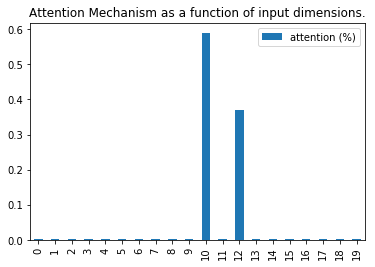

In [15]:
if __name__ == '__main__':

    N = 300000
    # N = 300 -> too few = no training
    inputs_1, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM)

    if APPLY_ATTENTION_BEFORE_LSTM:
        m = model_attention_applied_before_lstm()
    else:
        m = model_attention_applied_after_lstm()

    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit([inputs_1], outputs, epochs=1, batch_size=64, validation_split=0.1)

    attention_vectors = []
    for i in range(300):
        testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
        attention_vector = np.mean(get_activations(m,
                                                   testing_inputs_1,
                                                   print_shape_only=True,
                                                   layer_name='attention_vec')[0], axis=2).squeeze()
        print('attention =', attention_vector)
        assert (np.sum(attention_vector) - 1.0) < 1e-5
        attention_vectors.append(attention_vector)

    attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
    # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                         title='Attention Mechanism as '
                                                                               'a function of input'
                                                                               ' dimensions.')
    plt.show()
